In [1]:
# Jupyter notebook related
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [63]:
# Built-in modules
import os
import glob
import json
from typing import Tuple, List
from datetime import datetime, timedelta
import pickle
import shutil
import warnings
warnings.filterwarnings('ignore')

# Basics of Python data handling and visualization
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm

import rasterio as rio

# Data reading for training validation purposes:
#import sys
#sys.path.append('../starter_files/')
#from utils.data_transform import PlanetTransform, Sentinel1Transform, Sentinel2Transform
#from utils.planet_reader import PlanetReader
#from utils.sentinel_1_reader import S1Reader
#from utils.sentinel_2_reader import S2Reader
#from utils.data_loader import DataLoader
#from utils.baseline_models import SpatiotemporalModel
#from utils import train_valid_eval_utils as tveu
#from utils import unzipper

# Read Data

## Labels

* Labels for training are in two different files for two different locations
* In test labels crop_id and crop_name are not given

In [9]:
train_labels_dir_1 = "/home/dkrz/k202143/work/shared_data/2021-ai4food/raw_data/ref_fusion_competition_south_africa_train_labels/ref_fusion_competition_south_africa_train_labels_34S_19E_258N/labels.geojson"
train_labels_dir_2 = "/home/dkrz/k202143/work/shared_data/2021-ai4food/raw_data/ref_fusion_competition_south_africa_train_labels/ref_fusion_competition_south_africa_train_labels_34S_19E_259N/labels.geojson"

test_labels_dir = "/home/dkrz/k202143/work/shared_data/2021-ai4food/raw_data/ref_fusion_competition_south_africa_test_labels/ref_fusion_competition_south_africa_test_labels_34S_20E_259N/labels.geojson"

In [16]:
train_labels_1 = gpd.read_file(train_labels_dir_1)
train_labels_2 = gpd.read_file(train_labels_dir_2)
test_labels = gpd.read_file(test_labels_dir)

In [13]:
train_labels_1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1715 entries, 0 to 1714
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         1715 non-null   int64   
 1   SHAPE_AREA  1715 non-null   float64 
 2   SHAPE_LEN   1715 non-null   float64 
 3   crop_id     1715 non-null   int64   
 4   crop_name   1715 non-null   object  
 5   geometry    1715 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 80.5+ KB


In [14]:
train_labels_2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2436 entries, 0 to 2435
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         2436 non-null   int64   
 1   SHAPE_AREA  2436 non-null   float64 
 2   SHAPE_LEN   2436 non-null   float64 
 3   crop_id     2436 non-null   int64   
 4   crop_name   2436 non-null   object  
 5   geometry    2436 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 114.3+ KB


In [17]:
test_labels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2417 entries, 0 to 2416
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         2417 non-null   int64   
 1   SHAPE_AREA  2417 non-null   float64 
 2   SHAPE_LEN   2417 non-null   float64 
 3   crop_id     2417 non-null   int64   
 4   crop_name   2417 non-null   object  
 5   geometry    2417 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 113.4+ KB


In [18]:
train_labels_1.head()

,fid,SHAPE_AREA,SHAPE_LEN,crop_id,crop_name,geometry
0,80172,86608.783197,2165.333019,4,Lucerne/Medics,"MULTIPOLYGON (((456686.552 6215911.790, 456700..."
1,80217,129169.262104,1478.177480,2,Barley,"MULTIPOLYGON (((459030.598 6215734.313, 458988..."
2,80225,231420.387803,2007.104974,4,Lucerne/Medics,"MULTIPOLYGON (((458356.570 6216251.177, 458489..."
3,80228,100817.991529,1468.847742,4,Lucerne/Medics,"MULTIPOLYGON (((459818.661 6216018.564, 459809..."
4,80229,375263.554123,2693.791755,3,Canola,"MULTIPOLYGON (((459945.661 6215862.459, 460150..."


In [19]:
train_labels_2.head()

,fid,SHAPE_AREA,SHAPE_LEN,crop_id,crop_name,geometry
0,79963,12027.668825,814.527233,4,Lucerne/Medics,"MULTIPOLYGON (((456321.806 6226845.679, 456305..."
1,79964,56761.869844,1739.786627,4,Lucerne/Medics,"MULTIPOLYGON (((457064.228 6227434.842, 457014..."
2,79965,370996.533888,2658.880276,4,Lucerne/Medics,"MULTIPOLYGON (((457634.756 6229122.086, 458077..."
3,79966,284235.509210,2476.327088,2,Barley,"MULTIPOLYGON (((455999.863 6224509.152, 455999..."
4,79967,469157.021892,3564.716656,4,Lucerne/Medics,"MULTIPOLYGON (((455999.862 6224594.420, 455999..."


In [20]:
test_labels.head()

,fid,SHAPE_AREA,SHAPE_LEN,crop_id,crop_name,geometry
0,185471,336231.101354,3037.689838,0,No Data,"MULTIPOLYGON (((481218.487 6221463.526, 481076..."
1,185489,171191.578219,1824.826163,0,No Data,"MULTIPOLYGON (((480024.349 6222695.146, 480056..."
2,185490,19775.360170,687.957460,0,No Data,"MULTIPOLYGON (((480167.163 6222902.730, 480187..."
3,185495,362391.259505,2493.091528,0,No Data,"MULTIPOLYGON (((480708.563 6221905.165, 480680..."
4,185502,320166.272393,2181.246542,0,No Data,"MULTIPOLYGON (((480337.881 6221720.948, 480365..."


In [23]:
#CHECK LABEL IDs AND LABEL NAMES: 

label_ids_1 = train_labels_1['crop_id'].unique()
label_names_1 = train_labels_1['crop_name'].unique()
label_ids_2 = train_labels_2['crop_id'].unique()
label_names_2 = train_labels_2['crop_name'].unique()

print('INFO: Label IDs in file 1: {}'.format(label_ids_1))
print('INFO: Label Names in file 1: {}'.format(label_names_1))
print('INFO: Label IDs in file 2: {}'.format(label_ids_2))
print('INFO: Label Names in file 2: {}'.format(label_names_2))

INFO: Label IDs in file 1: [4 2 3 1 5]
INFO: Label Names in file 1: ['Lucerne/Medics' 'Barley' 'Canola' 'Wheat' 'Small grain grazing']
INFO: Label IDs in file 2: [4 2 5 1 3]
INFO: Label Names in file 2: ['Lucerne/Medics' 'Barley' 'Small grain grazing' 'Wheat' 'Canola']


The crops are not equally distributed:

INFO: Number of Fields by Crop Type: 
Lucerne/Medics         1792
Wheat                   753
Canola                  512
Barley                  661
Small grain grazing     433
Name: crop_name, dtype: int64


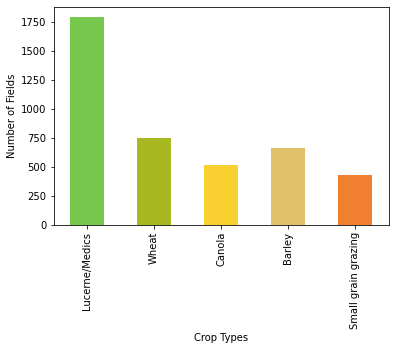

In [25]:
#CHECK FIELD DISTRIBUTION BY LABEL: 

value_counts =train_labels_1['crop_name'].value_counts()
value_counts += train_labels_2['crop_name'].value_counts()

colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 
ax=value_counts.plot.bar(color=colors_list)
ax.set_ylabel("Number of Fields")
ax.set_xlabel("Crop Types")

print('INFO: Number of Fields by Crop Type: \n{}'.format(value_counts))

INFO: Total Hectare per Crop Type: 
                   crop_name  total_hectare
crop_id                                    
1.0                    Wheat   14060.633983
2.0                   Barley   11491.487593
3.0                   Canola    9889.008658
4.0           Lucerne/Medics   20795.063533
5.0      Small grain grazing    6013.529840


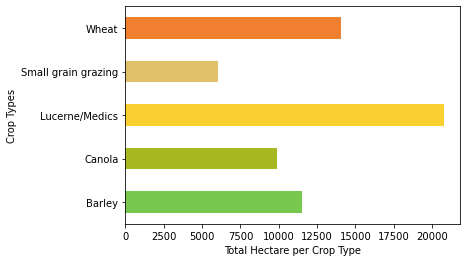

In [27]:
#CHECK TOTAL HECTARE DISTRIBUTION BY LABEL: 

hectare_distribution = pd.DataFrame(columns=["crop_name", "total_hectare"])
for group_1, group_2 in zip(train_labels_1.groupby('crop_name'),
                                       train_labels_2.groupby('crop_name')):
    crop_id=group_1[1].iloc[0]['crop_id']
    crop_name=group_1[0]
    total_hectare_1=group_1[1]['SHAPE_AREA'].sum()/10000 # convert to m2 to hectare
    total_hectare_2=group_2[1]['SHAPE_AREA'].sum()/10000 # convert to m2 to hectare
    total_hectare= total_hectare_1 + total_hectare_2
    
    hectare_distribution=hectare_distribution.append({'crop_id':crop_id, 'crop_name':crop_name, 'total_hectare':total_hectare}, ignore_index=True)

hectare_distribution.set_index('crop_id', inplace=True)
colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 
ax=hectare_distribution.plot.barh(color=colors_list,x='crop_name', y='total_hectare',legend=False)
ax.set_xlabel("Total Hectare per Crop Type")
ax.set_ylabel("Crop Types")

print('INFO: Total Hectare per Crop Type: \n{}'.format(hectare_distribution.sort_index()))

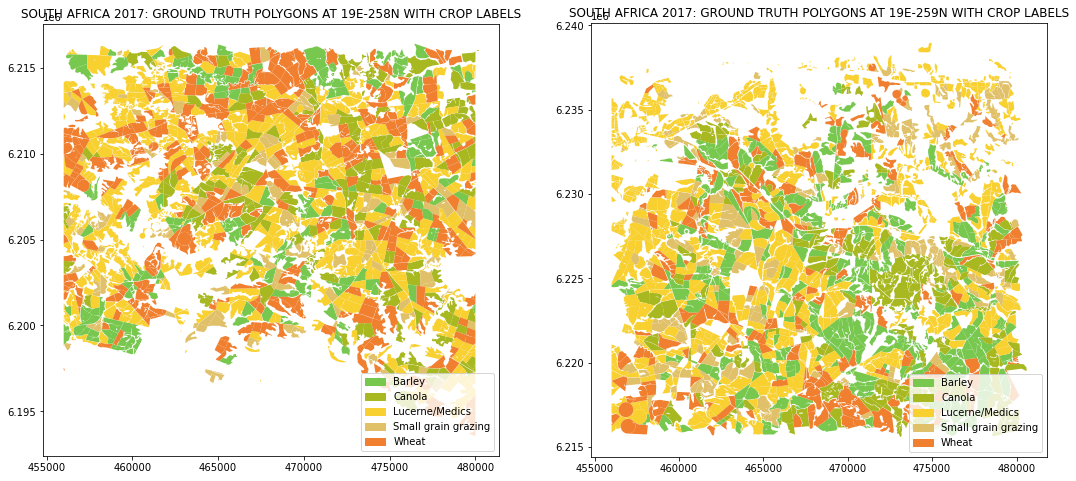

In [29]:
#DISPLAY TARGET FIELDS AT TILES '19E-258N' and '19E-259N' FOR TRAINING ON THE MAP BY LABEL: 

fig, axes = plt.subplots(1,2, figsize=(18, 18))
counter=0
legend_elements = []
for group_1, group_2 in zip(train_labels_1.groupby('crop_name'),
                            train_labels_2.groupby('crop_name')):
    
    group_1[1].plot(ax=axes[0],color=colors_list[counter], aspect=1)
    group_2[1].plot(ax=axes[1],color=colors_list[counter], aspect=1)
    
    legend_elements.append(Patch(facecolor=colors_list[counter], edgecolor=colors_list[counter],label=group_1[0]))
    counter+=1


axes[0].legend(handles=legend_elements,loc='lower right')
axes[0].title.set_text('SOUTH AFRICA 2017: GROUND TRUTH POLYGONS AT 19E-258N WITH CROP LABELS')

axes[1].legend(handles=legend_elements,loc='lower right')
axes[1].title.set_text('SOUTH AFRICA 2017: GROUND TRUTH POLYGONS AT 19E-259N WITH CROP LABELS')

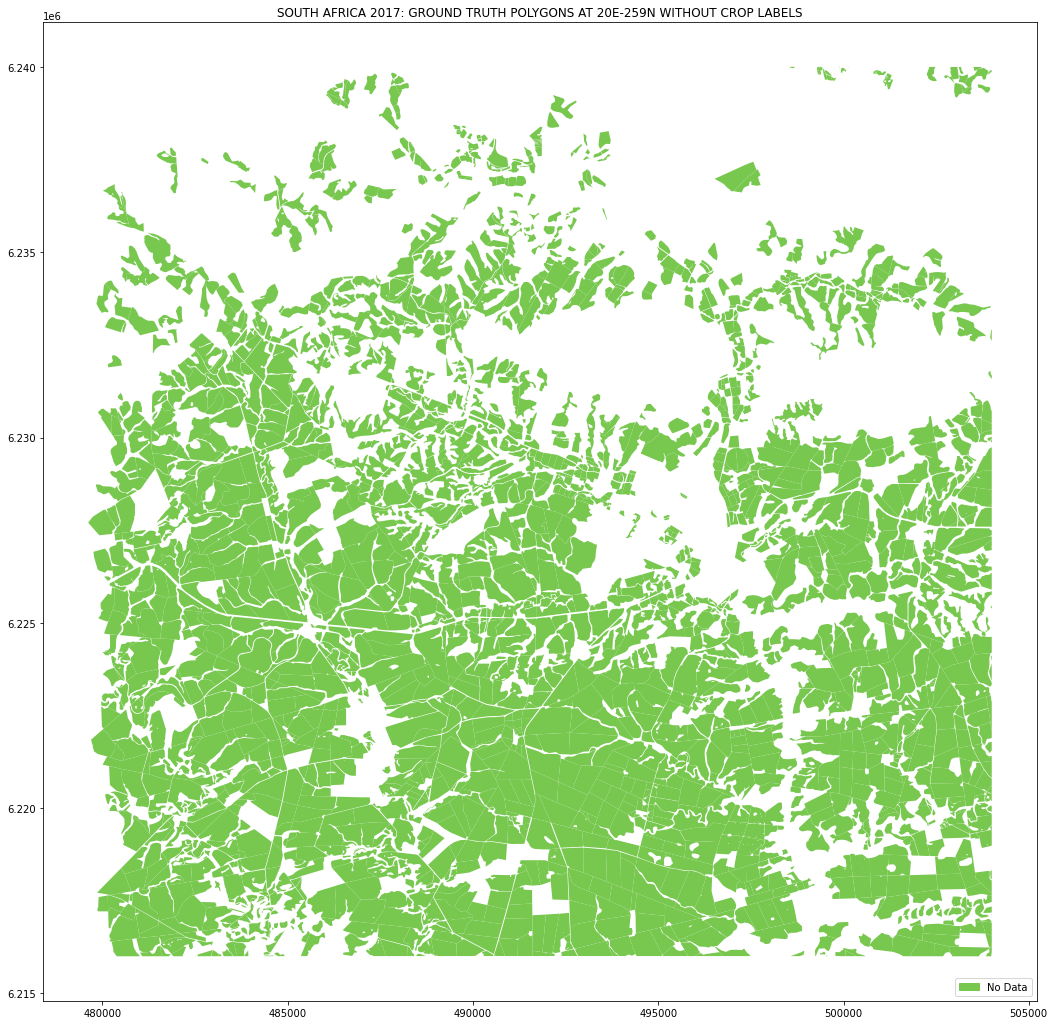

In [40]:
#DISPLAY TARGET FIELDS AT TILES '20E-259N' WITHOUT LABELS : 

south_africa_te_labels=gpd.read_file(test_labels_dir)
fig, ax = plt.subplots(figsize=(18, 18))
counter=0
legend_elements = []
for name, group in south_africa_te_labels.groupby('crop_name'):
    group.plot(ax=ax,color=colors_list[counter], aspect=1)
    legend_elements.append(Patch(facecolor=colors_list[counter], edgecolor=colors_list[counter],label=name))
    counter+=1

ax.legend(handles=legend_elements,loc='lower right')
ax.title.set_text('SOUTH AFRICA 2017: GROUND TRUTH POLYGONS AT 20E-259N WITHOUT CROP LABELS')

# Input Data
1. Planet Fusion Surface Reflection (PF-SR) imagery 
    * 4 channels: [blue, green, red, NIR]
    * 3-meter resolution
    * TIFF imaging format
    * free from clouds and shadows
    * daily gap-filled, high resolution, temporally consistent, radiometrically robust, harmonized and sensor agnostic surface reflectance time series
2. Sentinel-1 (S1) 
    * 3 channels: [VV, VH, ANGLE] where _V_ and _H_ stand for vertical and horizontal orientations, respectively, and ANGLE stores the angle of observation to the earth surface
3. Sentinel-2 (S2)
    * all L2A bands in the following order [B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]. The bands that have original spatial resolution of 20m and 60m are interpolated with a nearest-neighbour method to a 10m resolution
    
More infos and further links see starter notebook

In [41]:
#DIRECTORY OF PLANET FUSION TRAINING DATA AND LABELS:
# use lower temporal resolution for this notebook

planet_train_dir_1='/home/dkrz/k202143/work/shared_data/2021-ai4food/raw_data/ref_fusion_competition_south_africa_train_source_planet_5day/'
train_labels_dir_1='/home/dkrz/k202143/work/shared_data/2021-ai4food/raw_data/ref_fusion_competition_south_africa_train_labels/ref_fusion_competition_south_africa_train_labels_34S_19E_258N/labels.geojson'

planet_train_dir_2='/home/dkrz/k202143/work/shared_data/2021-ai4food/raw_data/ref_fusion_competition_south_africa_train_source_planet_5day'
train_labels_dir_2='/home/dkrz/k202143/work/shared_data/2021-ai4food/raw_data/ref_fusion_competition_south_africa_train_labels/ref_fusion_competition_south_africa_train_labels_34S_19E_259N/labels.geojson'

Nr 96
/home/dkrz/k202143/work/shared_data/2021-ai4food/raw_data/ref_fusion_competition_south_africa_train_source_planet_5day/ref_fusion_competition_south_africa_train_source_planet_5day_34S_19E_258N_2017_04_28/sr.tif
(8000, 8000)
(8000, 8000, 3)


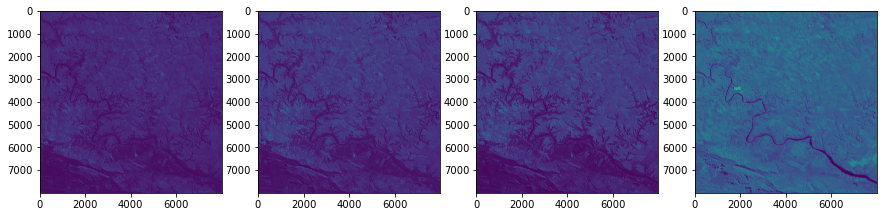

In [132]:
inputs_1 = glob.glob(planet_train_dir_1 + '/*/*.tif', recursive=True)
tifs = sorted(inputs)
print(f'Nr {len(tifs)}')
src = rio.open(tifs[5])
print(src.name)
array1 = src.read(1) # read channel 1
array2 = src.read(2) # read channel 2
array3 = src.read(3) # read channel 3
array4 = src.read(4) # read channel 4
print(array1.shape)
array = np.stack([array3, array2, array1], axis=-1)
print(array.shape)
fig, axs = plt.subplots(1, 4, figsize=(15,20))
axs[0].imshow(array1)
axs[1].imshow(array2)
axs[2].imshow(array3)
axs[3].imshow(array4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


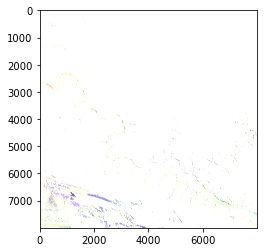

In [136]:
plt.imshow(array)

In [139]:
# SENTINEL-1 DATA
sentinel_1_train_dir_1 = '/home/dkrz/k202143/work/shared_data/2021-ai4food/raw_data/ref_fusion_competition_south_africa_train_source_sentinel_1/ref_fusion_competition_south_africa_train_source_sentinel_1_34S_19E_258N_asc_34S_19E_258N_2017'

In [140]:
vv = np.load(os.path.join(sentinel_1_train_dir_1, "vv.npy"))
vh = np.load(os.path.join(sentinel_1_train_dir_1, "vh.npy"))
angle = np.load(os.path.join(sentinel_1_train_dir_1, "angle.npy"))

In [142]:
print(f'V shape: {vv.shape}')
print(f'H shape: {vh.shape}')
print(f'angle shape: {angle.shape}')

V shape: (41, 2400, 2400, 1)
H shape: (41, 2400, 2400, 1)
angle shape: (41, 2400, 2400, 1)


In [147]:
with open(os.path.join(sentinel_1_train_dir_1, "bbox.pkl"), 'rb') as f:
            bbox = pickle.load(f)
            crs = str(bbox.crs)
            minx, miny, maxx, maxy = bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y


In [148]:
minx

455999.7703224362

In [149]:
# SENTINEL-2 DATA also saved as numpy arrays